In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

### Data Gathering

In [3]:
train_df = pd.read_excel("data_raw.xlsx")

a.	Bank: ATM belongs to which bank.

b.	ATMID: ID of the ATM.

c.	Cal date: Date 

d.	Dispense: Amount dispensed from an ATM on a particular day.

e.	DT: Time in minutes when ATM was down on a particular day.

f.	MaxCapacity: Maximum amount which can be loaded in the ATM.

g.	CountTotalTxn: Count of total number of transactions. 

In [4]:
train_df.columns = [ column.lower().replace(" ", "").replace("'", "") for column in train_df.columns]

In [5]:
train_df.rename(columns = {"atmid'":"atmid"}, inplace = True)

### Feature engineering

In [6]:
# Convert Caldate column to datetime format
train_df['caldate'] = pd.to_datetime(train_df['caldate'])
train_df['day'] = train_df['caldate'].dt.day_name()
train_df['IsWeekend'] = train_df['caldate'].dt.weekday.isin([5, 6])
train_df['Remaining_Cash'] = train_df['maxcapacity'] - train_df['dispense']
train_df['DispensePerTransaction'] = np.where(train_df['counttotaltxn'] > 0, train_df['dispense'] / train_df['counttotaltxn'], 0)

In [7]:
train_df.head()

,account,atmid,caldate,dispense,dt,maxcapacity,counttotaltxn,day,IsWeekend,Remaining_Cash,DispensePerTransaction
0,ABC,SPCN02020,2021-01-01,564500,0,2640000,157,Friday,False,2075500,3595.541401
1,ABC,TPCN10269,2021-01-01,509000,9,3520000,92,Friday,False,3011000,5532.608696
2,ABC,APCN00816,2021-01-01,64800,0,2640000,36,Friday,False,2575200,1800.000000
3,PQR,S1CN1142,2021-01-01,834500,0,3520000,101,Friday,False,2685500,8262.376238
4,PQR,S1CN2022,2021-01-01,825700,0,2860000,364,Friday,False,2034300,2268.406593


In [8]:
train_df.describe()

,dispense,dt,maxcapacity,counttotaltxn,Remaining_Cash,DispensePerTransaction
count,1.459300e+04,14593.000000,1.459300e+04,14593.000000,1.459300e+04,14593.000000
mean,4.027993e+05,158.538614,3.279753e+06,105.322963,2.876954e+06,3744.930924
std,3.036762e+05,356.073765,3.974770e+05,76.727151,4.590587e+05,2040.560997
min,0.000000e+00,0.000000,2.420000e+06,0.000000,7.257000e+05,0.000000
25%,1.685000e+05,0.000000,2.860000e+06,45.000000,2.578700e+06,2728.000000
50%,3.653000e+05,0.000000,3.520000e+06,98.000000,2.950900e+06,3514.492754
75%,5.780000e+05,64.000000,3.520000e+06,146.000000,3.230000e+06,4571.969697
max,2.151800e+06,1440.000000,3.740000e+06,561.000000,3.740000e+06,20000.000000


##### 1. Average dispense per transaction was approx 3800 Rs.

##### 2. Maximum transaction which took place was of 20,000 Rs.

##### 3. On average, 105 transactions happened in a single day.

##### 4. on average an ATM was down for approx 2.5 hours in a single day.


### Data quality check-

In [9]:
def check_data_quality(df):
    """
    Check the quality of a pandas DataFrame.
    """
    # Check for missing values
    missing_values = df.isnull().sum().sum()
    if missing_values > 0:
        print(f"WARNING: DataFrame contains {missing_values} missing values.")
    
    # Check for duplicate rows
    duplicate_rows = df.duplicated().sum()
    if duplicate_rows > 0:
        print(f"WARNING: DataFrame contains {duplicate_rows} duplicate rows.")
    
    # Check for irrelevant columns
    irrelevant_columns = df.apply(lambda col: col.nunique() == 1).sum()
    if irrelevant_columns > 0:
        print(f"WARNING: DataFrame contains {irrelevant_columns} irrelevant columns.")

In [10]:
check_data_quality(train_df)

# There are no duplicates, missing values & any irrelevant columns. 

In [11]:
for i in train_df.columns:
    if train_df[i].dtypes == 'object':
        unique_cat = len(train_df[i].unique())
        print("Feature '{i}' has {unique_cat} unique categories".format(i=i, unique_cat=unique_cat))

Feature 'account' has 3 unique categories
Feature 'atmid' has 21 unique categories
Feature 'day' has 7 unique categories


### Data insights using visuals -- (EDA)

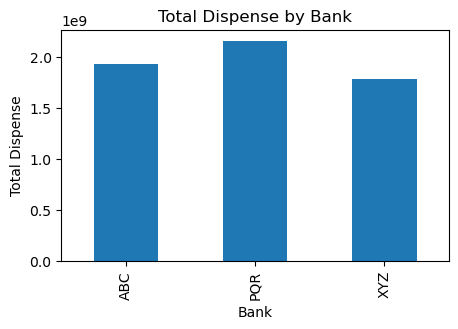

account
ABC    1928767000
PQR    2163687000
XYZ    1785596100
Name: dispense, dtype: int64

In [12]:
# Group data by Bank and visualize Dispense by Bank

plt.figure(figsize=(5,3))
train_df.groupby('account')['dispense'].sum().plot(kind='bar')
plt.title('Total Dispense by Bank')
plt.xlabel('Bank')
plt.ylabel('Total Dispense')
plt.show()
#To get the total dispensed amount by bank:
total_dispense_by_bank = train_df.groupby('account')['dispense'].sum()
total_dispense_by_bank

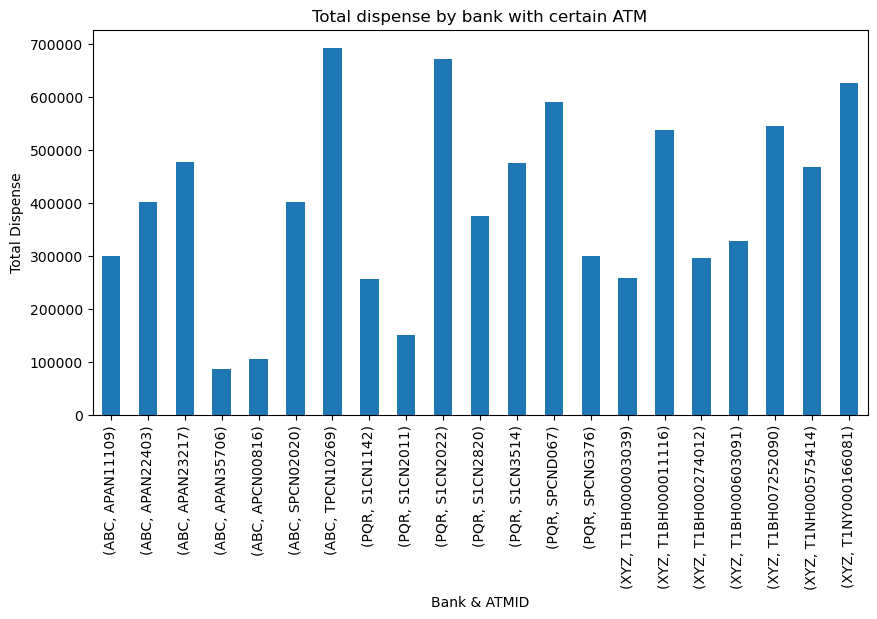

account  atmid        
ABC      TPCN10269        692686.206897
PQR      S1CN2022         671004.469987
XYZ      T1NY000166081    626145.083014
PQR      SPCND067         590157.088123
XYZ      T1BH007252090    545651.941748
         T1BH000011116    536735.007849
ABC      APAN23217        476889.399745
PQR      S1CN3514         474553.639847
XYZ      T1NH000575414    467214.309484
ABC      SPCN02020        402062.196679
Name: dispense, dtype: float64

In [13]:
#To get the top 10 ATMs with the highest average daily dispense:

plt.figure(figsize=(10,5))
train_df.groupby(['account','atmid'])['dispense'].mean().plot(kind='bar')
plt.title('Total dispense by bank with certain ATM')
plt.xlabel('Bank & ATMID')
plt.ylabel('Total Dispense')
plt.show()

top10_atms_dispense = train_df.groupby(['account','atmid'])['dispense'].mean().nlargest(10)
top10_atms_dispense

##### PQR has dispensed highest Cash as compared to ABC and XYZ. 

##### Top ATM for cash dispense is of ABC bank -- TPCN10269.

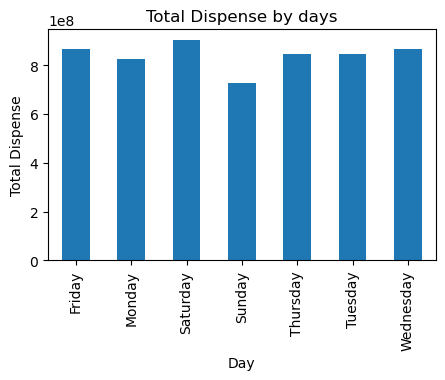

In [14]:
# Total Dispense by day.

plt.figure(figsize=(5,3))
train_df.groupby('day')['dispense'].sum().sort_index().plot(kind='bar', legend=None)
plt.title('Total Dispense by days')
plt.xlabel('Day')
plt.ylabel('Total Dispense')
plt.show()

In [15]:
days_list = []
for i in train_df.day:
    if i == 'Saturday' or i == 'Sunday':
        days_list.append('YES')
    else:
        days_list.append('NO')
        
train_df["Is_weekend"]=days_list
train_df.Is_weekend = train_df.Is_weekend.astype('category')

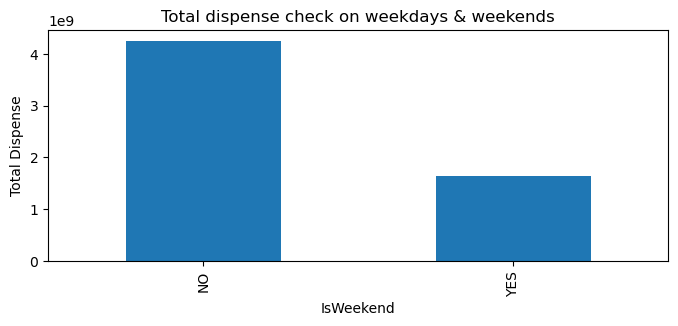

In [16]:
#Total dispense check on weekdays & weekends.

plt.figure(figsize=(8,3))
train_df.groupby('Is_weekend')['dispense'].sum().plot(kind='bar')
plt.title('Total dispense check on weekdays & weekends')
plt.xlabel('IsWeekend')
plt.ylabel('Total Dispense')
# plt.xticks([0,1], ['Weekday', 'Weekend'])
plt.show()

##### Weekday cash dispense is cummulatively higher than weekend.

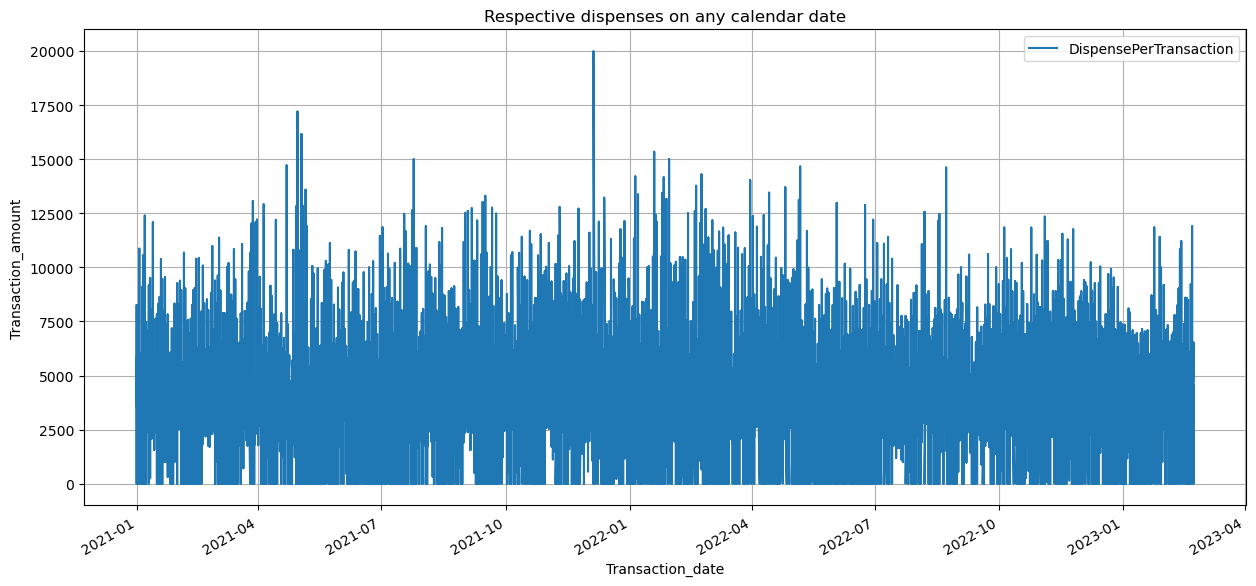

In [17]:
train_df.plot(x='caldate', y=['DispensePerTransaction'],kind='line', figsize=(15,7), grid=True)
plt.xlabel('Transaction_date')
plt.ylabel('Transaction_amount')
plt.title('Respective dispenses on any calendar date')
plt.show()

##### During 2021 May the average amount which was dispensed during a certain transaction is beyond 10k & reaching up to 17k.

##### During the end of 2021, we can see the maximum dispense which took place & the amount is of 20k.

##### Since last quarter of 2022 till current day, we can see the maximum dispensed amount in a certain transaction to be less than 12.5k 

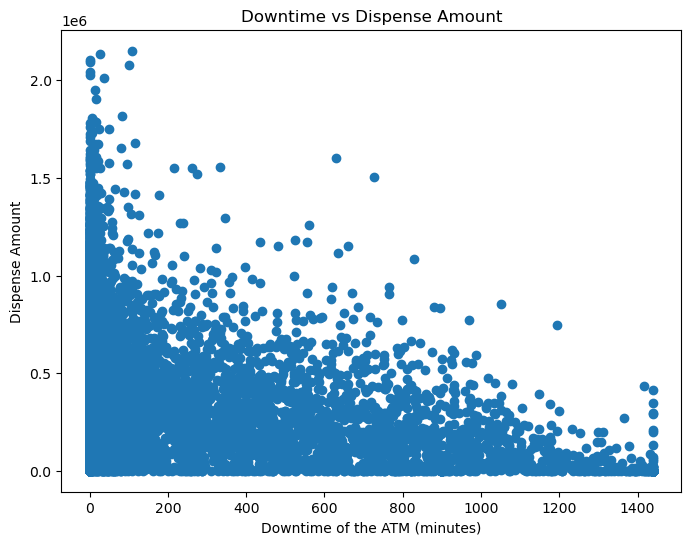

In [18]:
#identify if there is a correlation between downtime and dispense amount.
plt.figure(figsize=(8, 6))
plt.scatter(train_df['dt'], train_df['dispense'])
plt.title('Downtime vs Dispense Amount')
plt.xlabel('Downtime of the ATM (minutes)')
plt.ylabel('Dispense Amount')
plt.show()

##### Negative correlation between downtime of the ATM and dispense amount, it may indicate that the ATMs are not functioning and corrective action needs to be taken to improve their performance.

C:\Users\v-rohanraj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


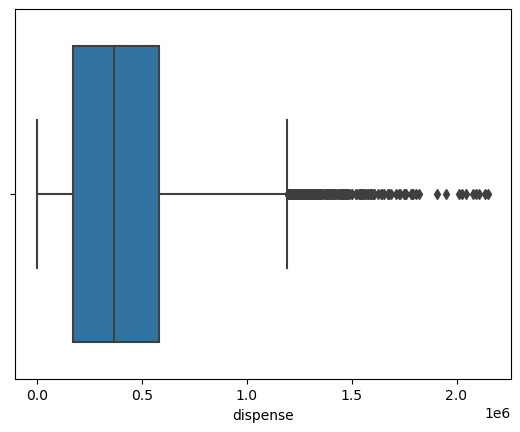

C:\Users\v-rohanraj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


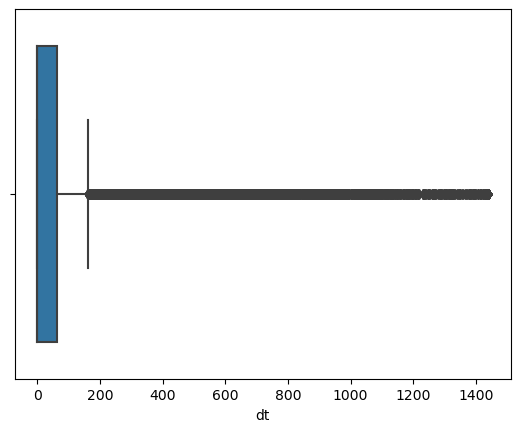

C:\Users\v-rohanraj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


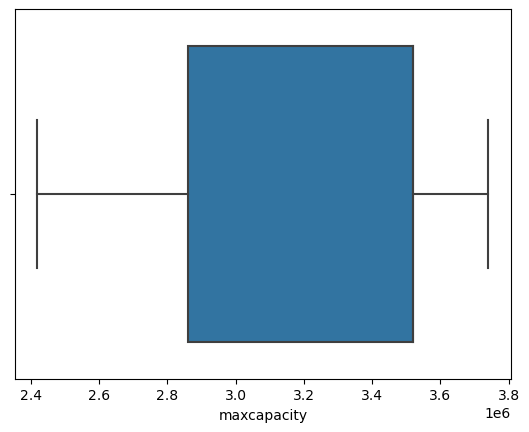

C:\Users\v-rohanraj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


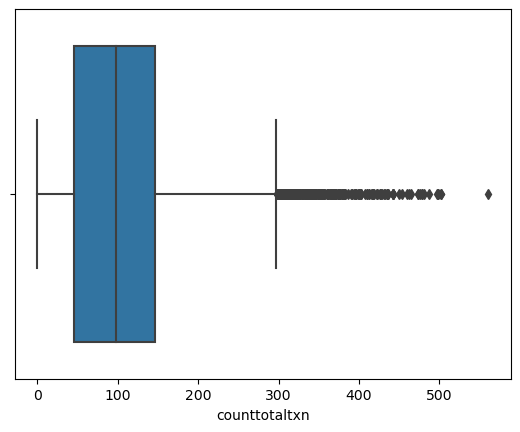

C:\Users\v-rohanraj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


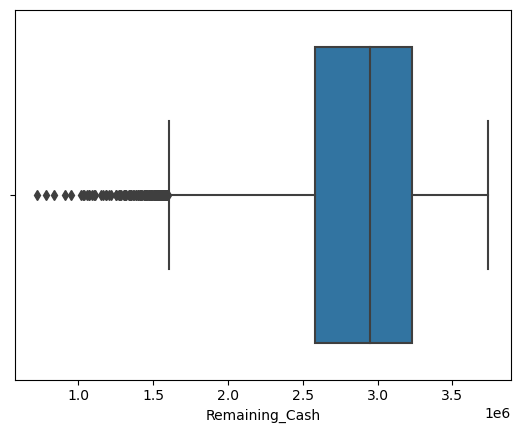

C:\Users\v-rohanraj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


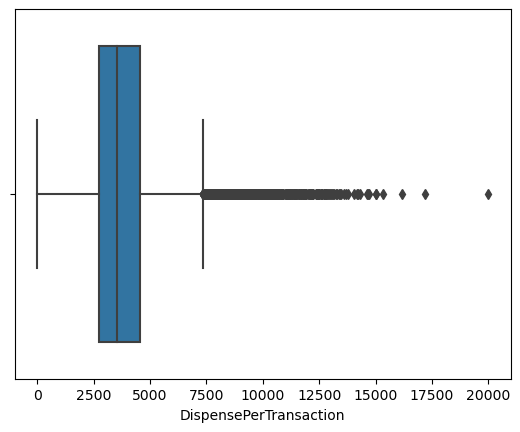

In [19]:
#Dealing with outliers.
for i in train_df.describe().columns:
    sns.boxplot(train_df[i].dropna())
    plt.show()
# Let's keep the outlier values as of now for the analysis.

##### An atm can be down for more than 3 hours on a particular day.

##### An atm generally can have 100 total transactions on any given day.

##### Note - We can see a lot of outliers in each of the features but would not remove or deal anyone right now but definitely if we want to create a better model then definitely a correct business understanding is required.

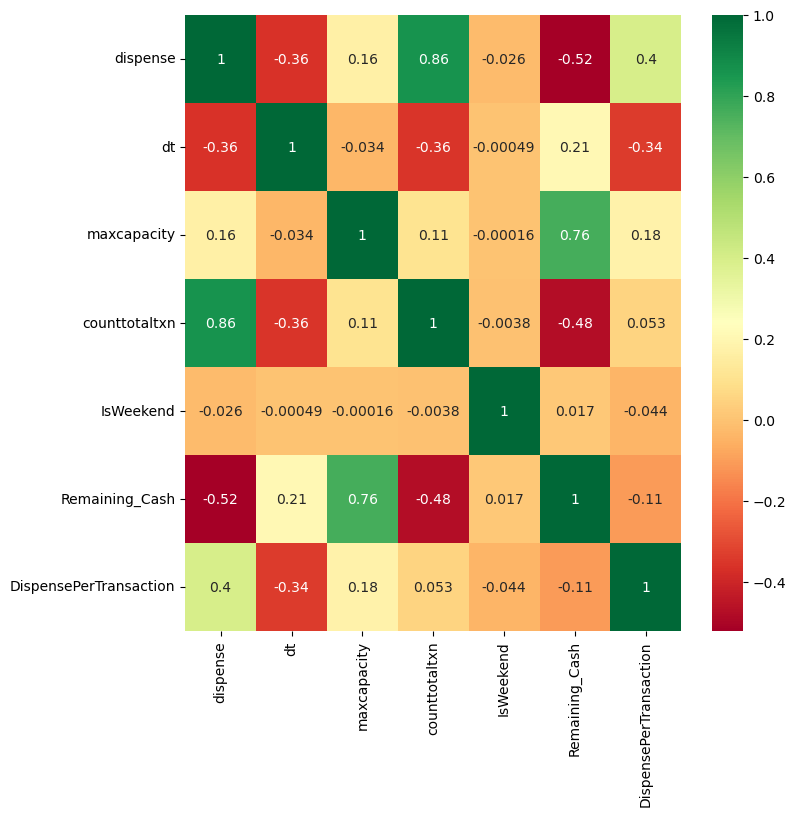

In [20]:
import seaborn as sns
corrmat = train_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,8))
g=sns.heatmap(train_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

##### We can see that count of total transactions in a day is highly correlated with dispense amount.

### Model Building

##### Let us create a model with all the above features.

In [21]:
# create a list of unique ATM IDs
atm_ids = train_df['atmid'].unique()
horizon = 7
LR_R2 = []
LR_MAE = []
LR_MSE = []
LR_RMSE = []

XG_R2 = []
XG_MAE = []
XG_MSE = []
XG_RMSE = []

RF_R2 = []
RF_MAE = []
RF_MSE = []
RF_RMSE = []

DT_R2 = []
DT_MAE = []
DT_MSE = []
DT_RMSE = []

# loop through each ATM ID and train a model to forecast dispense amount
for atm_id in atm_ids:
    # extract the data for the current ATM
    atm_data = train_df[train_df['atmid'] == atm_id] #train_df[train_df['atmid'] == i]
    
    # create the feature matrix and target vector
    
    X = atm_data[['dt', 'maxcapacity', 'counttotaltxn', 'DispensePerTransaction']]
    y = atm_data['dispense']
                        
        
    # split the data into training and validation sets
    split_index = len(atm_data) - horizon
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    sc= StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    ######LINEAR REGRESSION
    model=LinearRegression()
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    
    MAE=metrics.mean_absolute_error(y_test,pred)
    MSE=metrics.mean_squared_error(y_test,pred)
    RMSE=np.sqrt(MSE)
    r2=metrics.r2_score(y_test,pred)
    LR_R2.append(r2)
    LR_MAE.append(MAE)
    LR_MSE.append(MSE)
    LR_RMSE.append(RMSE)
    
    ######XGBOOST
    model_xgb=xgb.XGBRegressor()
    model_xgb.fit(X_train,y_train)
    pred=model_xgb.predict(X_test)
    
    MAE=metrics.mean_absolute_error(y_test,pred)
    MSE=metrics.mean_squared_error(y_test,pred)
    RMSE=np.sqrt(MSE)
    r2=metrics.r2_score(y_test,pred)
    XG_R2.append(r2)
    XG_MAE.append(MAE)
    XG_MSE.append(MSE)
    XG_RMSE.append(RMSE)
    
    ######Random Forest
    regressor = RandomForestRegressor()
    regressor.fit(X_train,y_train)
    pred = regressor.predict(X_test)
    
    MAE=metrics.mean_absolute_error(y_test,pred)
    MSE=metrics.mean_squared_error(y_test,pred)
    RMSE=np.sqrt(MSE)
    r2=metrics.r2_score(y_test,pred)
    RF_R2.append(r2)
    RF_MAE.append(MAE)
    RF_MSE.append(MSE)
    RF_RMSE.append(RMSE)
    
    ######Decision tree regressor
    MAE=metrics.mean_absolute_error(y_test,pred)
    MSE=metrics.mean_squared_error(y_test,pred)
    RMSE=np.sqrt(MSE)
    r2=metrics.r2_score(y_test,pred)
    DT_R2.append(r2)
    DT_MAE.append(MAE)
    DT_MSE.append(MSE)
    DT_RMSE.append(RMSE)
    
ind=['Linear regression','XGBoost Regression','Random Forest Regression','Decision Tree Regression']
data={"MAE":[np.mean(LR_MAE),np.mean(XG_MAE),np.mean(RF_MAE),np.mean(DT_MAE)],
      "MSE":[np.mean(LR_MSE),np.mean(XG_MSE),np.mean(RF_MSE),np.mean(DT_MSE)],
      "RMSE":[np.mean(LR_RMSE),np.mean(XG_RMSE),np.mean(RF_RMSE),np.mean(DT_RMSE)],
      "r2_Score":[np.mean(LR_R2),np.mean(XG_R2),np.mean(RF_R2),np.mean(DT_R2)]}
result=pd.DataFrame(data=data,index=ind)
result

,MAE,MSE,RMSE,r2_Score
Linear regression,46820.890847,4.462400e+09,58900.056313,0.479984
XGBoost Regression,7767.488861,1.466853e+08,10989.128015,0.982040
Random Forest Regression,6626.877551,1.311480e+08,9733.029728,0.982072
Decision Tree Regression,6626.877551,1.311480e+08,9733.029728,0.982072


##### Use K Fold cross validation to measure accuracy of our XGBOOST Regression model

In [22]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
cross_val_score(xgb.XGBRegressor(), X, y, cv=cv)
# Model is performing pretty well in every split.

array([0.99178494, 0.99050815, 0.99373932, 0.9744123 , 0.99037658,
       0.98483613, 0.99267717, 0.98681065, 0.98180704, 0.98646497])

##### Find best model using GridSearchCV

In [23]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
                'linear_regression' : {
                    'model': LinearRegression(),
                    'params': {
                        'normalize': [True, False]
                    }
                },
                'lasso': {
                    'model': Lasso(),
                    'params': {
                        'alpha': [1,2],
                        'selection': ['random', 'cyclic']
                    }
                },
                'decision_tree': {
                    'model': DecisionTreeRegressor(),
                    'params': {
                        'criterion' : ['mse','friedman_mse'],
                        'splitter': ['best','random']
                    }
                },
                'random_forest': {
                    'model':RandomForestRegressor(),
                    'params': {
                        'max_depth': [5, 10], 
                        'max_features': ['auto', 'log2'], 
                        'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]
                    }
                },
                'XGBBOOST_Regressor': {
                    'model':  xgb.XGBRegressor(),
                    'params': {
                                "learning_rate": (0.05, 0.10, 0.15),
                                "max_depth": [ 3, 4, 5, 6, 8],
                                "min_child_weight": [ 1, 3, 5, 7],
                                "gamma":[ 0.0, 0.1, 0.2],
                                "colsample_bytree":[ 0.3, 0.4],
                    }
                },
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [24]:
x=find_best_model_using_gridsearchcv(X,y)

C:\Users\v-rohanraj\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\v-rohanraj\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipelin

In [25]:
pd.set_option('display.max_rows', None)
x

,model,best_score,best_params
0,linear_regression,0.931806,{'normalize': True}
1,lasso,0.931806,"{'alpha': 2, 'selection': 'cyclic'}"
2,decision_tree,0.973040,"{'criterion': 'mse', 'splitter': 'best'}"
3,random_forest,0.984114,"{'max_depth': 10, 'max_features': 'auto', 'n_e..."
4,XGBBOOST_Regressor,0.959441,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn..."


In [26]:
# create a list of unique ATM IDs
atm_ids = train_df['atmid'].unique()
horizon = 7
final_df = pd.DataFrame()     #create dataframe that shows the predicted sales

# loop through each ATM ID and train a model to forecast dispense amount
for atm_id in atm_ids:
    # extract the data for the current ATM
    atm_data = train_df[train_df['atmid'] == atm_id] #train_df[train_df['atmid'] == i]
    
    # create the feature matrix and target vector
    
    X = atm_data[['dt', 'maxcapacity', 'counttotaltxn', 'DispensePerTransaction']]
    y = atm_data['dispense']
                        
    # split the data into training and validation sets
    split_index = len(atm_data) - horizon
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    # Scaling
    sc= StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    regressor = RandomForestRegressor(n_estimators = 100, random_state = 0, max_depth= 10, max_features= 'auto')
    regressor.fit(X_train,y_train)
    pred = regressor.predict(X_test)
    
    result_list = []
    sales_dates = list(atm_data[-7:].caldate) # To check the dispense amount from the ATM until next 7 days.
    for index in range(0,len(pred)):
        result_dict = {}
        result_dict['ATMID'] = atm_id
        result_dict['calendar_date'] = sales_dates[index]
        result_dict['Predicted_value'] = pred[index]
        result_dict['Actual_value'] = y_test.iloc[index]
        result_list.append(result_dict)
    df_result = pd.DataFrame(result_list)
    final_df = pd.concat([final_df,df_result],axis=0)

In [27]:
final_df

,ATMID,calendar_date,Predicted_value,Actual_value
0,SPCN02020,2023-02-16,0.000000,0
1,SPCN02020,2023-02-17,73601.416667,74000
2,SPCN02020,2023-02-18,363001.468839,363000
3,SPCN02020,2023-02-19,318867.451734,316000
4,SPCN02020,2023-02-20,47826.000000,58500
5,SPCN02020,2023-02-21,0.000000,0
6,SPCN02020,2023-02-22,167681.172619,176000
0,TPCN10269,2023-02-16,647287.528682,645200
1,TPCN10269,2023-02-17,438766.524802,441900
2,TPCN10269,2023-02-18,406839.904595,406500


In [28]:
# Write output to csv
final_df.to_csv('Prediction.csv', index=False)